# Section 3.3: DeepSurv Demo

Author: George H. Chen (georgechen [at symbol] cmu.edu)

This demo covers how to implement DeepSurv (Faraggi and Simon, 1995; Katzman et al., 2018) using PyCox and PyTorch. For an overview of how DeepSurv works, please see Section 3.3 in the monograph. This demo largely builds off the exponential time-to-event prediction model demo (`S2.2.2_Exponential.ipynb`), so please look at that first as it describes the different steps of the experimental setup in more detail. In this demo, we specifically use PyCox's `CoxPH` model (which is a Python class), which--despite its name seeming to mean the classical Cox proportional hazards model--actually implements DeepSurv.

While this demo can be understood without first looking at the DeepHit demo (`S2.3.3_DeepHit_single.ipynb`), we think it could be helpful to also look at the DeepHit demo as a point of comparison--importantly, whereas DeepHit requires time to be discretized prior to model training, DeepSurv does not.

*Disclaimer:* Note that PyCox actually uses various conventions that are not standard in terms of working with PyTorch (it relies heavily on another package `torchtuples` by the same author as PyCox). Our demo here intentionally tries to stick to what would be considered standard PyTorch conventions (so that as a warning up front, what we present here does *not* perfectly align with the demos that come with PyCox but will more closely resemble how PyTorch is commonly used in many other settings, including for instance how model training works in TorchSurv). The key reason why we stick to standard PyTorch conventions is so that the code makes various preprocessing and model training steps more transparent, so that if you want to modify any part of these, it should be easier to do so (for instance, if you want to introduce a specific learning rate schedule, if you want to add early stopping based on a validation set integrated Brier score, if you want to control for randomness in a particular way using your own data loaders or specific random number generators, etc).

### Loading in the SUPPORT dataset (Knaus et al., 1995)

As with the earlier demo, we begin by defining the training, validation, and test sets.

In [1]:
from datasets import load_dataset
from sklearn.model_selection import train_test_split

X_full_train_raw_np, Y_full_train_np, D_full_train_np, \
        X_test_raw_np, Y_test_np, D_test_np, \
        features_before_preprocessing, features_after_preprocessing, \
        events, train_test_split_prespecified, \
        build_preprocessor_and_preprocess, apply_preprocessor = load_dataset('support')

# split the "full training set" into the actual training set and a validation set (using a 80/20 split)
X_train_raw_np, X_val_raw_np, Y_train_np, Y_val_np, D_train_np, D_val_np = \
    train_test_split(X_full_train_raw_np, Y_full_train_np, D_full_train_np,
                     test_size=.2, random_state=0)

print(f'Training set size {X_train_raw_np.shape[0]}')
print(f'Validation set size {X_val_raw_np.shape[0]}')
print(f'Test set size {X_test_raw_np.shape[0]}')
print()

print(f'Features before preprocessing ({len(features_before_preprocessing)} total):')
print(features_before_preprocessing)
print()

print(f'Features after preprocessing ({len(features_after_preprocessing)} total):')
print(features_after_preprocessing)
print()

print('Events:', events)  # only one critical event for the standard time-to-event prediction setup
print()

Training set size 4968
Validation set size 1243
Test set size 2662

Features before preprocessing (14 total):
['age', 'female', 'race', 'num.co', 'diabetes', 'dementia', 'ca', 'meanbp', 'hrt', 'resp', 'temp', 'wblc', 'sod', 'crea']

Features after preprocessing (19 total):
['age_std', 'female', 'num.co_norm', 'diabetes', 'dementia', 'ca_norm', 'meanbp_std', 'hrt_std', 'resp_std', 'temp_std', 'wblc_std', 'sod_std', 'crea_std', 'race_blank', 'race_asian', 'race_black', 'race_hispanic', 'race_other', 'race_white']

Events: ['death']



We fit and apply a preprocessor to the training set. We apply (but do not re-fit) the preprocessor to the validation set.

In [2]:
X_train_np, preprocessor = build_preprocessor_and_preprocess(X_train_raw_np)
X_val_np = apply_preprocessor(X_val_raw_np, preprocessor)

### Preparing training and validation sets for use with PyTorch

In [3]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train = torch.tensor(X_train_np, dtype=torch.float32, device=device)
Y_train = torch.tensor(Y_train_np, dtype=torch.float32, device=device)
D_train = torch.tensor(D_train_np, dtype=torch.int32, device=device)
train_data = list(zip(X_train, Y_train, D_train))

X_val = torch.tensor(X_val_np, dtype=torch.float32, device=device)
Y_val = torch.tensor(Y_val_np, dtype=torch.float32, device=device)
D_val = torch.tensor(D_val_np, dtype=torch.int32, device=device)
val_data = list(zip(X_val, Y_val, D_val))

### Setting up the DeepSurv model and loss

Note that the base neural net needs to output a single number corresponding to the log partial hazard function. There is no need to have a bias for the final linear layer since the bias would just get absorbed into the baseline hazard function.

In [4]:
import torch.nn as nn
from pycox.models import CoxPH

torch.manual_seed(0)

num_input_features = X_train.size(1)

base_neural_net = nn.Sequential(nn.Linear(num_input_features, 8),
                                nn.ReLU(),
                                nn.Linear(8, 1, bias=False)).to(device)

deepsurv_model = CoxPH(base_neural_net, device=device)
deepsurv_loss = deepsurv_model.loss

### Step 1 of the training procedure in Section 3.3 of the monograph: Training the log partial hazards model using minibatch gradient descent

Just as in the exponential time-to-event prediction model demo, we use the validation set to decide on whether to use a previous epoch's learned model parameters.

In [5]:
from copy import deepcopy
from torch.utils.data import DataLoader

# minibatch gradient descent
num_epochs = 100
batch_size = 128
learning_rate = 1e-2

train_loader = DataLoader(train_data, batch_size, shuffle=True)  # shuffling for minibatch gradient descent
val_loader = DataLoader(val_data, batch_size, shuffle=False)  # there is no need to shuffle the validation data

optimizer = torch.optim.Adam(base_neural_net.parameters(), lr=learning_rate)
train_epoch_losses = []
val_epoch_losses = []
best_val_loss = float('inf')
best_params = None
best_epoch_index = None
for epoch_index in range(num_epochs):
    base_neural_net.train()
    for X_batch, Y_batch, D_batch in train_loader:
        neural_net_output = base_neural_net(X_batch)
        loss_batch = deepsurv_loss(neural_net_output, Y_batch, D_batch)

        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()

    # evaluate training and validation set losses
    # (note that in practice, instead of evaluating the negative log likelihood loss,
    # we could instead evaluate other metrics such as time-dependent concordance index,
    # integrated Brier score, etc)
    base_neural_net.eval()
    with torch.no_grad():
        train_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in train_loader:
            batch_num_points = X_batch.size(0)
            neural_net_output = base_neural_net(X_batch)
            train_loss += deepsurv_loss(neural_net_output, Y_batch, D_batch) * batch_num_points
            num_points += batch_num_points
        train_loss = float(train_loss / num_points)
        train_epoch_losses.append(train_loss)
        print(f'Epoch {epoch_index + 1} - train loss {train_loss}', end=' ', flush=True)

        val_loss = torch.tensor(0.0, dtype=torch.float, device=device)
        num_points = 0
        for X_batch, Y_batch, D_batch in val_loader:
            batch_num_points = X_batch.size(0)
            neural_net_output = base_neural_net(X_batch)
            val_loss += deepsurv_loss(neural_net_output, Y_batch, D_batch) * batch_num_points
            num_points += batch_num_points
        val_loss = float(val_loss / num_points)
        val_epoch_losses.append(val_loss)
        print(f'- val loss {val_loss}', flush=True)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch_index = epoch_index
            best_params = deepcopy(base_neural_net.state_dict())
print(f'Best validation loss ({best_val_loss}) achieved at epoch {best_epoch_index + 1}')
base_neural_net.load_state_dict(best_params)

Epoch 1 - train loss 4.232234954833984 - val loss 4.257750511169434
Epoch 2 - train loss 4.221454620361328 - val loss 4.250138759613037
Epoch 3 - train loss 4.219745635986328 - val loss 4.252907752990723
Epoch 4 - train loss 4.217616081237793 - val loss 4.248834609985352
Epoch 5 - train loss 4.2164740562438965 - val loss 4.2465410232543945
Epoch 6 - train loss 4.214822769165039 - val loss 4.243216514587402
Epoch 7 - train loss 4.215346336364746 - val loss 4.249841213226318
Epoch 8 - train loss 4.210739612579346 - val loss 4.241546630859375
Epoch 9 - train loss 4.209824562072754 - val loss 4.245884895324707
Epoch 10 - train loss 4.208444118499756 - val loss 4.243304252624512
Epoch 11 - train loss 4.208667278289795 - val loss 4.241664409637451
Epoch 12 - train loss 4.20735502243042 - val loss 4.240788459777832
Epoch 13 - train loss 4.206737518310547 - val loss 4.243132591247559
Epoch 14 - train loss 4.205790996551514 - val loss 4.24213171005249
Epoch 15 - train loss 4.204240322113037 - v

<All keys matched successfully>

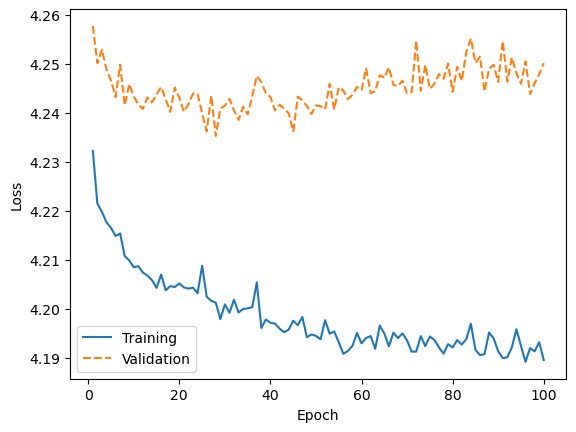

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), train_epoch_losses, label='Training')
plt.plot(range(1, num_epochs + 1), val_epoch_losses, '--', label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

### Step 2 of the training procedure in Section 3.3 of the monograph: Fitting the baseline hazard function

Note that the discrete time grid used by PyCox is the unique times in `Y_train_np`.

In [7]:
deepsurv_model.compute_baseline_hazards(input=X_train_np.astype('float32'),
                                        target=(Y_train_np.astype('float32'),
                                                D_train_np.astype('int32')))

duration
3.0       0.025753
4.0       0.054722
5.0       0.044133
6.0       0.036240
7.0       0.041364
            ...   
2024.0    0.000000
2026.0    0.000000
2027.0    0.000000
2028.0    0.000000
2029.0    0.000000
Name: baseline_hazards, Length: 1444, dtype: float64

### Predicting test set survival curves

We begin by preprocessing the test data using the preprocessor built using training data.

In [8]:
X_test_np = apply_preprocessor(X_test_raw_np, preprocessor).astype('float32')

PyCox has built-in functionality for predicting survival functions:

In [9]:
surv_test_df = deepsurv_model.predict_surv_df(X_test_np, batch_size=batch_size)
surv_test_df

,0,1,2,3,4,5,6,7,8,9,...,2652,2653,2654,2655,2656,2657,2658,2659,2660,2661
duration,,,,,,,,,,,,,,,,,,,,,
3.0,0.973468,0.975779,0.987826,0.983264,0.987372,0.994474,0.986331,0.983465,0.986049,0.995728,...,0.989334,0.987810,0.983889,0.983533,0.992576,0.982749,0.983570,0.972109,0.982421,0.980892
4.0,0.919406,0.926243,0.962448,0.948626,0.961067,0.982834,0.957905,0.949234,0.957048,0.986711,...,0.967046,0.962399,0.950511,0.949436,0.976984,0.947074,0.949550,0.915399,0.946087,0.941492
5.0,0.878001,0.888131,0.942456,0.921581,0.940364,0.973546,0.935576,0.922496,0.934282,0.979498,...,0.949437,0.942382,0.924419,0.922801,0.964587,0.919249,0.922972,0.872082,0.917765,0.910873
6.0,0.845398,0.858010,0.926351,0.899951,0.923697,0.965985,0.917631,0.901105,0.915992,0.973614,...,0.935217,0.926257,0.903530,0.901489,0.954526,0.897012,0.901705,0.838050,0.895144,0.886476
7.0,0.809663,0.824876,0.908304,0.875882,0.905034,0.957426,0.897569,0.877294,0.895554,0.966942,...,0.919247,0.908188,0.880263,0.877764,0.943169,0.872287,0.878028,0.800825,0.870004,0.859426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024.0,0.033594,0.045311,0.213152,0.118845,0.201149,0.496961,0.176077,0.121962,0.169831,0.582582,...,0.258394,0.212717,0.128769,0.123017,0.390486,0.111244,0.123614,0.028161,0.106656,0.087619
2026.0,0.033594,0.045311,0.213152,0.118845,0.201149,0.496961,0.176077,0.121962,0.169831,0.582582,...,0.258394,0.212717,0.128769,0.123017,0.390486,0.111244,0.123614,0.028161,0.106656,0.087619
2027.0,0.033594,0.045311,0.213152,0.118845,0.201149,0.496961,0.176077,0.121962,0.169831,0.582582,...,0.258394,0.212717,0.128769,0.123017,0.390486,0.111244,0.123614,0.028161,0.106656,0.087619


In [10]:
surv_test_np = surv_test_df.to_numpy().T
time_grid_train_np = surv_test_df.index.to_numpy()

Here's a plot of the predicted survival function for the 0th test data point:

Text(0, 0.5, 'Survival probability')

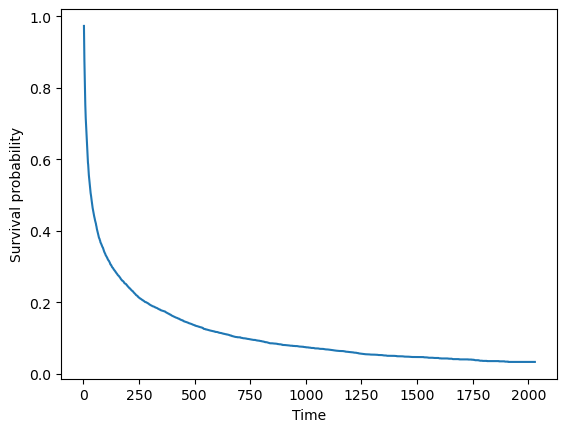

In [11]:
plt.plot(time_grid_train_np, surv_test_np[0])
plt.xlabel('Time')
plt.ylabel('Survival probability')

### Computing test set evaluation metrics

For choosing evaluation times, we use the test set's observed times.

In [12]:
import numpy as np
time_grid_test_np = np.unique(Y_test_np)

#### Time-dependent concordance index (Antolini et al., 2005) using the PyCox implementation (Kvamme et al., 2019)

In [13]:
from pycox.evaluation import EvalSurv

eval_pycox = EvalSurv(surv_test_df, Y_test_np, D_test_np)
C_td = eval_pycox.concordance_td('antolini')
print(f'Time-dependent concordance index: {C_td}')

Time-dependent concordance index: 0.610701496709868


#### Truncated time-dependent concordance index (Uno et al., 2011) using the scikit-survival implementation (Pölsterl, 2020)

In [14]:
from sksurv.util import Surv
from sksurv.metrics import concordance_index_ipcw

# convert training and test labels into the structured array format used by scikit-survival
labels_train_sksurv = Surv.from_arrays(D_train_np, Y_train_np)
labels_test_sksurv = Surv.from_arrays(D_test_np, Y_test_np)

# as an illustrative example, we evaluate the truncated time-dependent concordance index at
# 25, 50, and 75 percentile values of the time grid we specified earlier
eval_time_indices = [int(.25 * len(time_grid_test_np)),
                     int(.5 * len(time_grid_test_np)),
                     int(.75 * len(time_grid_test_np))]

for eval_time_index in eval_time_indices:
    eval_time = time_grid_test_np[eval_time_index]

    # find the training time grid's time point closest to the evaluation time
    interp_time_index = np.argmin(np.abs(eval_time - time_grid_train_np))
    surv_values_at_eval_time_np = surv_test_np[:, interp_time_index]

    estimated_risks_np = 1 - surv_values_at_eval_time_np
    concordance = concordance_index_ipcw(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, tau=eval_time)[0]
    print(f'Eval time {eval_time} - truncated time-dependent concordance: {concordance}')

Eval time 316.0 - truncated time-dependent concordance: 0.6061113486082409
Eval time 693.0 - truncated time-dependent concordance: 0.6110931896771314
Eval time 1291.0 - truncated time-dependent concordance: 0.6117946842068762


#### Time-dependent AUC (Uno et al., 2007; Hung and Chiang, 2010) using the scikit-survival implementation (Pölsterl, 2020)

In [15]:
from sksurv.metrics import cumulative_dynamic_auc

for eval_time_index in eval_time_indices:
    eval_time = time_grid_test_np[eval_time_index]

    # find the training time grid's time point closest to the evaluation time
    interp_time_index = np.argmin(np.abs(eval_time - time_grid_train_np))
    surv_values_at_eval_time_np = surv_test_np[:, interp_time_index]

    estimated_risks_np = 1 - surv_values_at_eval_time_np
    AUC = cumulative_dynamic_auc(labels_train_sksurv, labels_test_sksurv, estimated_risks_np, times=[eval_time])[0][0]
    print(f'Eval time {eval_time} - time-dependent AUC: {AUC}')

Eval time 316.0 - time-dependent AUC: 0.6653015691699965
Eval time 693.0 - time-dependent AUC: 0.6999602190340523
Eval time 1291.0 - time-dependent AUC: 0.7079045183054151


#### Brier score (Graf et al., 1999) using the SurvivalEVAL implementation (Qi et al., 2024)

In [16]:
from SurvivalEVAL.Evaluator import SurvivalEvaluator

eval = SurvivalEvaluator(surv_test_np, time_grid_train_np,
                         Y_test_np, D_test_np,
                         Y_train_np, D_train_np)  # note: training labels are also needed

for eval_time_index in eval_time_indices:
    eval_time = float(time_grid_test_np[eval_time_index])
    print(f'Eval time {eval_time} - Brier score: {eval.brier_score(eval_time)}')

IBS = eval.integrated_brier_score()
print(f'Integrated Brier score: {IBS}')

Eval time 316.0 - Brier score: 0.2280812189176826


/home/george/anaconda3/lib/python3.12/site-packages/SurvivalEVAL/Evaluator.py:59: UserWarning: The first time coordinate is not 0. A authentic survival curve should start from 0 with 100% survival probability. \Adding 0 to the beginning of the time coordinates and 1 to the beginning of the predicted curves.
  warnings.warn("The first time coordinate is not 0. "


Eval time 693.0 - Brier score: 0.20567825100918427
Eval time 1291.0 - Brier score: 0.18449317051788744
Integrated Brier score: 0.1854886838100155


#### D-Calibration (Haider et al., 2020) using the SurvivalEVAL implementation (Qi et al., 2024)

In [17]:
p_value, bin_stats = eval.d_calibration()
if p_value >= .05:
    print('The model is D-calibrated.')
else:
    print('The model is not D-calibrated.')

The model is not D-calibrated.


#### Mean Absolute Error via the margin (Haider et al., 2020) and, separately, the Pseudo Observation approach (Qi et al., 2023) both using the SurvivalEVAL implementation (Qi et al., 2024)

In [18]:
weighted_MAE_margin = eval.mae(method='Margin', weighted=True)
print(f'Weighted MAE-Margin: {weighted_MAE_margin}')

Weighted MAE-Margin: 615.0655919527228


In [19]:
weighted_MAE_PO = eval.mae(method='Pseudo_obs', weighted=True)
print(f'Weighted MAE-PO: {weighted_MAE_PO}')

Weighted MAE-PO: 720.8059698432095
